In [1]:
%load_ext autoreload
%autoreload 2

# Mono View Upper Side

In [7]:
from train_monoview_network import TrainMonoInputModel
from mono_view_classification_network import MonoInputModel
from config import get_config

import torch
from tqdm import tqdm
from torchvision import datasets
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, balanced_accuracy_score, accuracy_score
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
from copy import deepcopy

In [3]:
model_config, data_config = get_config()

In [4]:
trainer = TrainMonoInputModel(model_config,data_config)
# trainer.train_and_validate()

[INFO]: Loading pre-trained weights
[INFO]: Freezing hidden layers...


In [6]:
model = model_config['model']            
model = MonoInputModel(model,pretrained=True, fine_tune=False, num_classes=7)
checkpoint = torch.load(f'{trainer.main_path}/outputs/model_EfficientNet_mono_RECTO_epochs_30_lr_0.001_batch_size_32_pretrained_True_fine_tune_False.pth', map_location="cuda")
print('Loading trained model weights...')
model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(trainer.device)

[INFO]: Loading pre-trained weights
[INFO]: Freezing hidden layers...
Loading trained model weights...


## Multiple combinations

In [9]:
class Identity(torch.nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x

def modified_resnet(model):
    model.fc = Identity()
    return model

def modified_densenet(model):
    model.classifier = Identity()
    return model 

In [10]:
import torchvision
models = [{'model':torchvision.models.efficientnet_b5(weights='IMAGENET1K_V1'),
                                      'avgpool':torch.nn.AdaptiveAvgPool2d(1),
                                      'last_layer_size':2048,
                                      'model_name' : 'EfficientNet',
                                       'features' : None
          },
          {'model':torchvision.models.densenet121(weights='IMAGENET1K_V1'),
                                  'avgpool':None,
                                  'last_layer_size':1024,
                                  'model_name' : 'DenseNet121',
                                   'features' : modified_densenet(torchvision.models.densenet121(weights='IMAGENET1K_V1')),
            },
          {'model':torchvision.models.resnet50(weights='IMAGENET1K_V1'),
                                  'avgpool':None,
                                  'last_layer_size':2048,
                                  'model_name' : 'ResNet50',
                                   'features' : modified_resnet(torchvision.models.resnet50(weights='IMAGENET1K_V1'))
            },
          {'model':torchvision.models.vgg16(weights='IMAGENET1K_V1'),
                                  'avgpool':torch.nn.AdaptiveAvgPool2d((1,1)),
                                  'last_layer_size':512,
                                  'model_name' : 'VGG',
                                   'features' : None
            },
          
          {'model':torchvision.models.resnet152(weights='IMAGENET1K_V1'),
                                  'avgpool':None,
                                  'last_layer_size':2048,
                                  'model_name' : 'ResNet152',
                                   'features' : modified_resnet(torchvision.models.resnet152(weights='IMAGENET1K_V1'))
            }
          
]

## Train and Validate

In [11]:
import os
"""
for model in models :
    model_config = {'learning_rate' : 0.001,
                      "epochs" : 30,
                      "pretrained":True,
                      "fine_tune":False,
                        "model":model,
                     }
    trainer = TrainMonoInputModel(model_config,data_config,pretrained=True,fine_tune=False)
    save_file = f"model_{model['model_name']}_mono_{trainer.side}_epochs_{trainer.epochs}_lr_{trainer.lr}_batch_size_{trainer.batch_size}_pretrained_{trainer.pretrained}_fine_tune_{trainer.fine_tune}.pth"
    if save_file not in os.listdir('/home/onyxia/work/pfe-deep-learning-maladies-plantes/mono_vue_torch/outputs'):
        print(model['model_name'])
        trainer.train_and_validate()"""


'\nfor model in models :\n    model_config = {\'learning_rate\' : 0.001,\n                      "epochs" : 30,\n                      "pretrained":True,\n                      "fine_tune":False,\n                        "model":model,\n                     }\n    trainer = TrainMonoInputModel(model_config,data_config,pretrained=True,fine_tune=False)\n    save_file = f"model_{model[\'model_name\']}_mono_{trainer.side}_epochs_{trainer.epochs}_lr_{trainer.lr}_batch_size_{trainer.batch_size}_pretrained_{trainer.pretrained}_fine_tune_{trainer.fine_tune}.pth"\n    if save_file not in os.listdir(\'/home/onyxia/work/pfe-deep-learning-maladies-plantes/mono_vue_torch/outputs\'):\n        print(model[\'model_name\'])\n        trainer.train_and_validate()'

## Models Evaluation

In [12]:
import ptflops as ptf
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, balanced_accuracy_score, accuracy_score, f1_score, precision_score, recall_score, roc_auc_score


In [13]:
y_obs = []
for i, recto in tqdm(enumerate(trainer.testloader), total=len(trainer.testloader)):
        image_recto, labels = recto
        y_obs.append(labels.tolist())
y_obs = [item for sublist in y_obs for item in sublist]

100%|██████████| 91/91 [00:32<00:00,  2.79it/s]


In [14]:
import os
#all_models_weight = [f for f in os.listdir('/home/onyxia/work/pfe-deep-learning-maladies-plantes/multi_vue_pytorch/outputs') if f.endswith(".pth")]
lb=["Alt","Big","Mac","Mil","Myc","Pse","Syl"]
le = preprocessing.LabelEncoder()
le.fit(lb)
all_outputs = {}
for modelR in models :
    temp = {}
    model_config = {'learning_rate' : 0.001,
                  "epochs" : 30,
                  "pretrained":True,
                  "fine_tune":False,
                    "model": deepcopy(modelR),
                 }
    trainer = TrainMonoInputModel(model_config,data_config)
    model = MonoInputModel(modelR,pretrained=True, fine_tune=False, num_classes=7)
    checkpoint = torch.load(f'{trainer.main_path}/outputs/model_{model.name}_mono_{trainer.side}_epochs_{trainer.epochs}_lr_{trainer.lr}_batch_size_{trainer.batch_size}_pretrained_{trainer.pretrained}_fine_tune_{trainer.fine_tune}.pth', map_location="cuda")
    #model.load_state_dict({cle: checkpoint['model_state_dict'][cle] for cle in checkpoint['model_state_dict'].keys() if not cle.startswith("modelRecto.") and not cle.startswith("modelVerso.")})
    model.load_state_dict(checkpoint['model_state_dict'])
    model = model.to(trainer.device)
    trainer.model = model
    preds, max_probs, all_probs = trainer.predict(trainer.testloader)
    macs,_ = ptf.get_model_complexity_info(trainer.model, (3, 224, 224), as_strings=False,
                                               print_per_layer_stat=False, verbose=False)
    all_outputs[model.name] = {
     "pred" : le.inverse_transform(preds).tolist(),
     "max_probs" : max_probs,
    "all_probs" : all_probs,
     "accuracy" : accuracy_score(y_obs,preds),
     "balanced_accuracy" : balanced_accuracy_score(y_obs,preds),
     "precision_micro" : precision_score(y_obs,preds,average="micro"),
    "recall_micro" : recall_score(y_obs,preds,average="micro"),
    "precision_micro" : precision_score(y_obs,preds,average="micro"),
    "recall_micro" : recall_score(y_obs,preds,average="micro"),
    "roc_auc_micro" : roc_auc_score(y_obs,all_probs,average="micro",multi_class='ovr'),
    "f1_score_micro" : f1_score(y_obs,preds,average="micro"),
    "precision_weighted" : precision_score(y_obs,preds,average="weighted"),
    "recall_weighted" : recall_score(y_obs,preds,average="weighted"),
    "precision_weighted" : precision_score(y_obs,preds,average="weighted"),
    "recall_weighted" : recall_score(y_obs,preds,average="weighted"),
    "roc_auc_weighted" : roc_auc_score(y_obs,all_probs,average="weighted",multi_class='ovo'),
    "f1_score_weighted" : f1_score(y_obs,preds,average="weighted"),
     "nb_trainable_parameters" : sum(
        p.numel() for p in trainer.model.parameters() if p.requires_grad),
     "nb_parameters" : sum(
        p.numel() for p in trainer.model.parameters()),
    "macs" : macs
    }

[INFO]: Loading pre-trained weights
[INFO]: Freezing hidden layers...
[INFO]: Loading pre-trained weights
[INFO]: Freezing hidden layers...


  0%|          | 0/91 [00:00<?, ?it/s]

[INFO]: Loading pre-trained weights
[INFO]: Freezing hidden layers...
[INFO]: Loading pre-trained weights
[INFO]: Freezing hidden layers...


  0%|          | 0/91 [00:00<?, ?it/s]

[INFO]: Loading pre-trained weights
[INFO]: Freezing hidden layers...
[INFO]: Loading pre-trained weights
[INFO]: Freezing hidden layers...


  0%|          | 0/91 [00:00<?, ?it/s]

[INFO]: Loading pre-trained weights
[INFO]: Freezing hidden layers...
[INFO]: Loading pre-trained weights
[INFO]: Freezing hidden layers...


  0%|          | 0/91 [00:00<?, ?it/s]

[INFO]: Loading pre-trained weights
[INFO]: Freezing hidden layers...
[INFO]: Loading pre-trained weights
[INFO]: Freezing hidden layers...


  0%|          | 0/91 [00:00<?, ?it/s]

In [20]:
with open("outputs/test_results_mono_recto_full.json","w",encoding='utf-8') as f:
    json.dump(all_outputs, f, ensure_ascii=False, indent=4)

In [21]:
with open("outputs/test_results_mono_recto_full.json") as f:
    all_outputs = json.load(f)

### Plot macs/accuracy/parameters

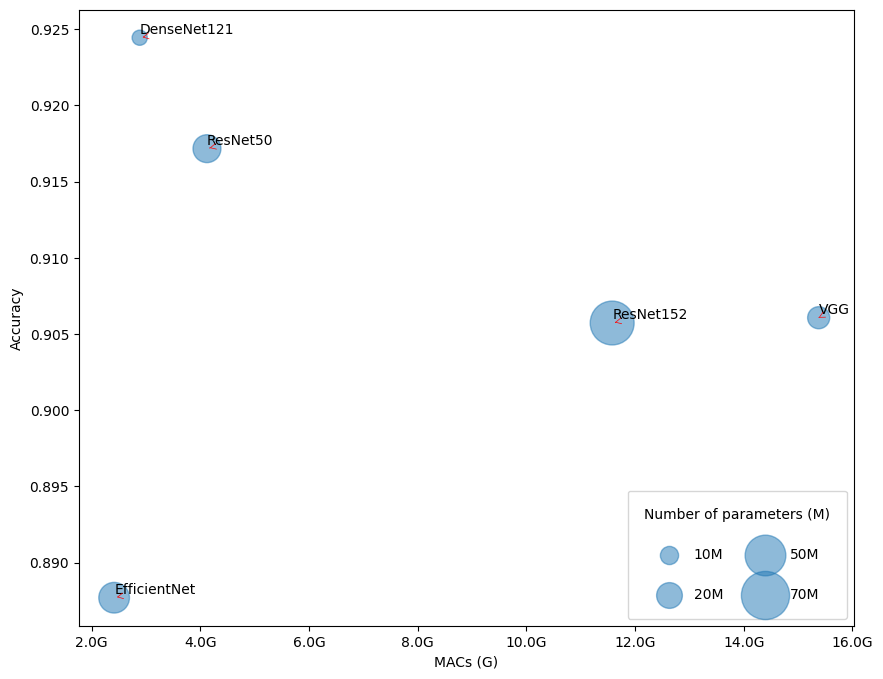

In [19]:
import matplotlib.pyplot as plt
from adjustText import adjust_text
# Préparation des données pour le graphique
names = []
macs = []
accuracy = []
params = []
max_params = max(values['nb_parameters'] for values in all_outputs.values())
for name, values in all_outputs.items():
    names.append(name)
    macs.append(values['macs'] / 1e9)  # Convert MACs to GigaMACs
    accuracy.append(values['accuracy'])
    params.append((values['nb_parameters'] / max_params) * 1000)

fig, ax = plt.subplots(figsize=(10, 8))
scatter = ax.scatter(macs, accuracy, s=params, alpha=0.5, c='C0')

plt.xlabel('MACs (G)')
plt.ylabel('Accuracy')

# Format x-axis tick labels as scientific notation with "G" unit
ax.ticklabel_format(axis='x', style='sci', scilimits=(0, 0))
ax.xaxis.offsetText.set_visible(False)
ax.xaxis.set_major_formatter('{x:.1f}G')
sizes = [10**7, 20*10**6, 50*10**6, 70*10**6]  # Define different sizes for the circles
labels = [f'{s/(10**6):.0f}M' for s in sizes]  # Define labels for the legend
handles = [plt.scatter([], [], s=(s/max_params)*1000, alpha=0.5,c="C0") for s in sizes]  # Create dummy scatter plots for the legend
legend = plt.legend(handles, labels, title='Number of parameters (M)', scatterpoints=1, labelspacing=1.9, loc='lower right',ncol=2,borderpad=1.2)
plt.setp(legend.get_title(), fontsize='medium')
# Ajout des annotations
texts = []
for x, y, s in zip(macs, accuracy, names):
    texts.append(plt.text(x, y, s))
adjust_text(texts, only_move={'points':'y', 'texts':'y'}, arrowprops=dict(arrowstyle="->", color='r', lw=0.5))
plt.show()
fig.savefig("outputs/model_performance_plot_acc_mac.pdf",format="pdf")

### Table with results

In [24]:
dict_res = {key1: { key2 : all_outputs[key1][key2] for key2 in ["accuracy","balanced_accuracy","precision_micro","precision_weighted","recall_micro","f1_score_micro","f1_score_weighted","roc_auc_micro","roc_auc_weighted"]} for key1 in all_outputs.keys() }
pd_res = pd.DataFrame(dict_res).transpose()
pd_res.columns = ["accuracy","balanced accuracy","precision micro","precision weighted","recall micro","f1-score micro","f1-score weighted","roc auc micro","roc auc weighted"]
pd_res.sort_values(by="accuracy",ascending=False)

,accuracy,balanced accuracy,precision micro,precision weighted,recall micro,f1-score micro,f1-score weighted,roc auc micro,roc auc weighted
DenseNet121,0.924437,0.920965,0.924437,0.925277,0.924437,0.924437,0.923220,0.994934,0.994030
ResNet50,0.917158,0.910497,0.917158,0.918397,0.917158,0.917158,0.915686,0.994156,0.993845
VGG,0.906066,0.902359,0.906066,0.906714,0.906066,0.906066,0.906032,0.993310,0.991792
ResNet152,0.905719,0.898563,0.905719,0.907734,0.905719,0.905719,0.904485,0.993335,0.992515
EfficientNet,0.887695,0.880988,0.887695,0.886241,0.887695,0.887695,0.886325,0.989899,0.987937


#### Matrice de confusion pour le meilleur modèle

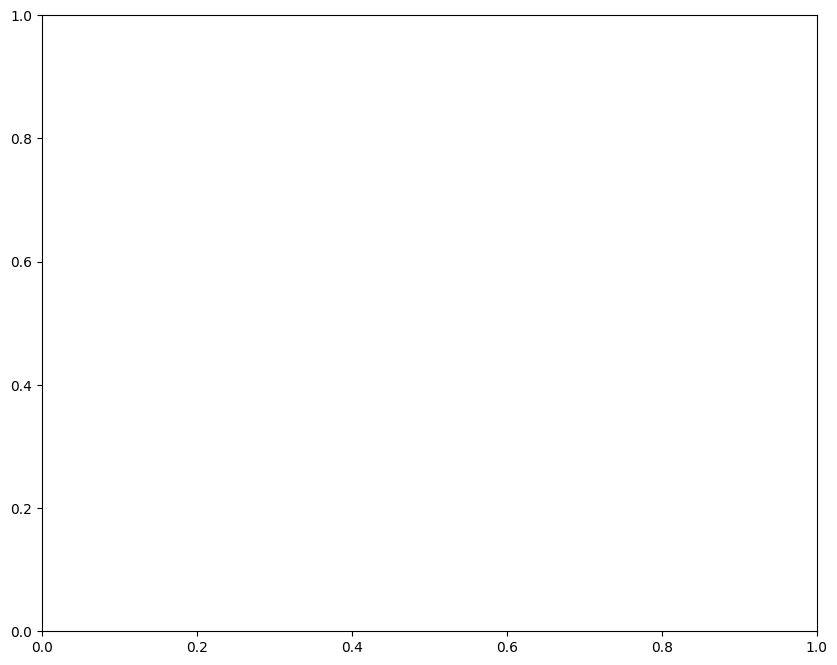

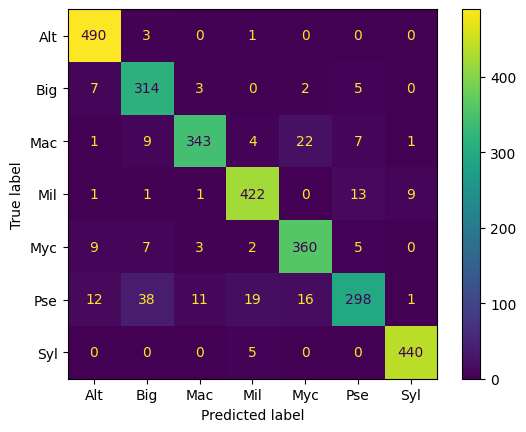

Accuracy : 0.9244367417677642
Balanced Accuracy : 0.9209652467223836


In [34]:
y_pred=all_outputs['DenseNet121']['pred']
#y_obs=real_labels
# let's use sklearn
lb=["Alt","Big","Mac","Mil","Myc","Pse","Syl"]
le = preprocessing.LabelEncoder()
le.fit(lb)
#y_pred=le.inverse_transform(y_pred)
#y_obs=le.inverse_transform(y_obs)
fig, ax = plt.subplots(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_obs,
y_pred,labels=lb),display_labels=lb)
disp.plot()
plt.show()
print("Accuracy : "+str(accuracy_score(y_obs, y_pred)))
print("Balanced Accuracy : "+str(balanced_accuracy_score(y_obs, y_pred)))

fig.savefig("outputs/cmatrixR.png",format="png")